In [20]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
# import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from imblearn.under_sampling import RandomUnderSampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load binding data 

In [17]:
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/'
train_x_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainX.csv")
train_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainY.csv")
test_x_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testX.csv")
test_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testY.csv")
train_x = torch.from_numpy(train_x_df.to_numpy())
train_y = torch.from_numpy(train_y_df.to_numpy().reshape(-1))
test_x = torch.from_numpy(test_x_df.to_numpy())
test_y = torch.from_numpy(test_y_df.to_numpy().reshape(-1))


# Undersample 

In [18]:
# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_x = scaling.transform(train_x_df)
test_x = scaling.transform(test_x_df) 

undersample = RandomUnderSampler()
train_x_temp, train_y_temp = undersample.fit_resample(train_x, train_y_df)
train_x = train_x_temp
train_y = train_y_temp.to_numpy().flatten()
test_y = test_y_df.to_numpy().flatten()


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.622, precision: 0.080, recall: 0.750, sensitivity: 0.750, specificity: 0.616


<Axes: title={'center': 'Undersample NEK2 Binding Test: Basic RF'}, xlabel='Predicted label', ylabel='True label'>

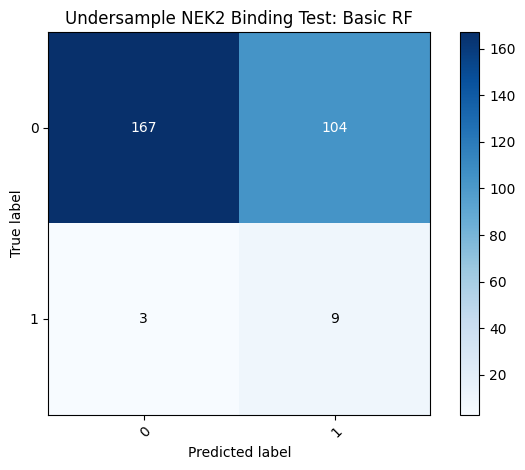

In [23]:
rf_basic100estUNDER = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {}, 'binding')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, rf_basic100estUNDER['test_pred'], ['0','1'], title='Undersample NEK2 Binding Test: Basic RF')

# Reduced param grid for grid search - RUN IN BASH SCRIPT 

In [17]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [ ]:
# save_file = 'atom_nek2bindUNDER_rf_basic_best.pkl'
# rf_basicbestUNDER = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid,  save_file, 2)

In [ ]:
with open(save_file, 'rb') as f: 
    rf_basicbestUNDER = pickle.load(f) 


# Basic RF + classweight balanced 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.625, precision: 0.080, recall: 0.750, sensitivity: 0.750, specificity: 0.620


<Axes: title={'center': 'Undersample NEK2 Binding Test: RF + Balanced Class Weight'}, xlabel='Predicted label', ylabel='True label'>

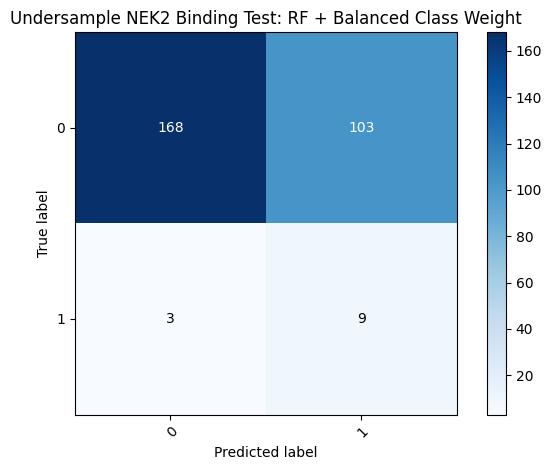

In [22]:
brf_model_BCW_UNDER = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, 'binding')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, brf_model_BCW_UNDER['test_pred'], ['0','1'], title='Undersample NEK2 Binding Test: RF + Balanced Class Weight')

In [ ]:
save_file2 = 'atom_nek2bindUNDER_rf_basicBCW_best.pkl'
# rf_basicBCWbestUNDER = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid,  save_file2, 2)
with open(save_file2, 'rb') as f: 
    rf_basicBCWbestUNDER = pickle.load(f) 


# Balanced Random Forest Classifier

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.618, precision: 0.071, recall: 0.667, sensitivity: 0.667, specificity: 0.616


<Axes: title={'center': 'Undersample NEK2 Binding Test: Balanced RFC'}, xlabel='Predicted label', ylabel='True label'>

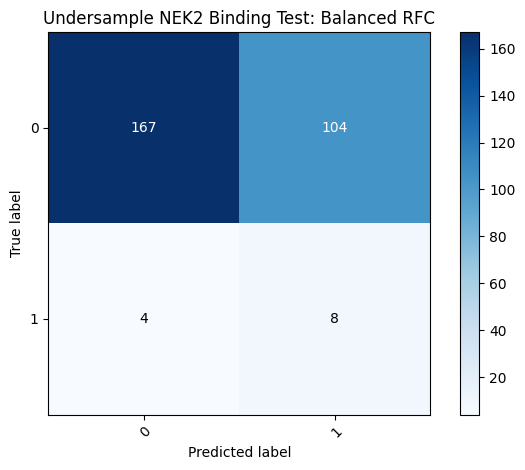

In [24]:
brf_modelUNDER = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, 'binding')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, brf_modelUNDER['test_pred'], ['0','1'], title='Undersample NEK2 Binding Test: Balanced RFC')

In [ ]:
save_file3 = 'atom_nek2bindUNDER_BRFC_best.pkl'
# brfc_bestUNDER = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, param_grid,  save_file3, 2)
with open(save_file3, 'rb') as f: 
    brfc_bestUNDER = pickle.load(f) 


# Try BRFC with balanced class weight & bootstrap

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.629, precision: 0.073, recall: 0.667, sensitivity: 0.667, specificity: 0.627


<Axes: title={'center': 'Undersample NEK2 Binding Test: Balanced RFC + Balanced Class Weight'}, xlabel='Predicted label', ylabel='True label'>

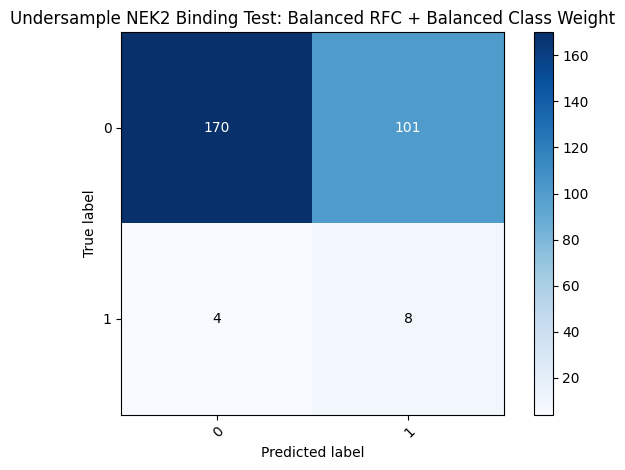

In [25]:
brf_modelCWB_UNDER = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, 'binding')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, brf_modelCWB_UNDER['test_pred'], ['0','1'], title='Undersample NEK2 Binding Test: Balanced RFC + Balanced Class Weight')

In [14]:
save_file4 = 'atom_nek2bindUNDER_BRFC_BCW_best.pkl'
# brfc_BCW_UNDER_best = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, param_grid,  save_file4, 2)
with open(save_file4, 'rb') as f: 
    brfc_BCW_UNDER_best = pickle.load(f) 


FileNotFoundError: [Errno 2] No such file or directory: 'atom_nek2bindUNDER_BRFC_BCW_best.pkl'